In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import quantumsolver as qs

# help(qs.fewnucleonEmulator)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)


In [2]:
# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 13

cD_grid = np.linspace(-2.5, 2.5, 100)
cE_grid = np.linspace(-1., 1., 100)

# Create a 2-dimensional grid
cD_eval, cE_eval = np.meshgrid(cD_grid,cE_grid)


In [84]:

def constraint_plotter(cD_eval, cE_eval, efterror=False):

    E4He_eval, Rp4He_eval, _, E3He_eval, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)
            
    fig, ax = plt.subplots()

    x = 1

    mean_E4He = -28.296 # np.mean(E4He_eval)
    mean_Rp4He = 1.4552  # np.mean(Rp4He_eval)
    mean_E3H = -8.482 # np.mean(E3H_eval) 
    mean_fT3H = 1129.6 #np.mean(fT3H_eval)

    sigma_E3H = 0.015
    sigma_E4He = 0.005
    sigma_Rp4He = 0.0062
    sigma_fT3H = 3.

    if efterror:
        sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
        sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
        sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
        sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))
        ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

    cs= ax.contourf(cD_eval, cE_eval, fT3H_eval, levels=[mean_fT3H-x*sigma_fT3H, mean_fT3H+x*sigma_fT3H], colors='gray', alpha=0.2)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='black')
    cs = ax.contourf(cD_eval, cE_eval, Rp4He_eval, levels=[mean_Rp4He-x*sigma_Rp4He, mean_Rp4He+x*sigma_Rp4He], colors='#ffb16d', alpha=0.85)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#e17701')
    cs = ax.contourf(cD_eval, cE_eval, E3H_eval, levels=[mean_E3H-x*sigma_E3H, mean_E3H+x*sigma_E3H], colors='#7af9ab', alpha=0.8)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#2baf6a', linestyles='-')
    cs = ax.contourf(cD_eval, cE_eval, E4He_eval, levels=[mean_E4He-x*sigma_E4He, mean_E4He+x*sigma_E4He], colors='dodgerblue', alpha=0.5)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='dodgerblue', linestyles='-')

    return ax

def customizer(ax):

    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    ax.text(0.4, -0.85, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.5, -0.7, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-0.5, .1, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, -0.2, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

save = False
efterror = False

### Comment after one use for customization of text boxes by changing
### the customizer function
#ax = constraint_plotter(cD_eval, cE_eval, efterror=efterror)

for txt in ax.texts[1:]:
    txt.set_visible(False)
    ax.texts[1:].remove(txt)

customizer(ax)

fig = ax.get_figure()
if efterror and save:
    fig.savefig('figs/constraints_EFT_exp.pdf', bbox_inches='tight')
elif save:
    fig.savefig('figs/constraints_noEFT_exp.pdf', bbox_inches='tight')


In [12]:
import emcee
import scipy.stats as stats
import corner

sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))

def log_prior(params):
    
    cD, cE = params
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (np.sum(stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma)) + 
            np.sum(stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)))   

def log_likelihood(params, data_set):
    cD, cE = params
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # mean_E4He = np.mean(E4He) # -28.296
    # mean_Rp4He = np.mean(Rp4He) # 1.4552
    # mean_E3H = np.mean(E3H) # -8.482
    # mean_fT3H = np.mean(fT3H) # 1129.6

    if len(data_set) == 2:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) + 
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)))
    elif len(data_set) == 4:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) +
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)) +
                np.sum(stats.norm.logpdf(E3H, -8.482, sigma_E3H)) +
                np.sum(stats.norm.logpdf(fT3H, 1129.6, sigma_fT3H)))

def log_posterior(params, data_set):
    return log_prior(params) + log_likelihood(params, data_set)

cD = np.random.normal(0., 5, 50)
cE = np.random.normal(0., 5, 50)

pos = np.vstack((cD, cE))

nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He, E3H, fT3H)])
burn = sampler.run_mcmc(pos.T, 100, progress=True)
sampler.reset()

sampler.run_mcmc(burn, 1000, progress=True)

100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s]


State([[ 1.91149924e+00  1.03780033e-01]
 [ 1.75282651e+00  1.19122484e-01]
 [ 8.28456828e-01 -9.64922034e-02]
 [ 5.76437107e-01 -8.05426441e-02]
 [ 1.43755984e+00  4.24453672e-02]
 [ 8.80160000e-01 -4.25492061e-02]
 [ 1.45615158e+00  4.00955907e-02]
 [ 1.21121540e+00  5.03864972e-02]
 [ 1.65799158e+00  6.54353107e-02]
 [ 8.63893483e-01 -6.10416661e-03]
 [ 1.99468852e+00  5.90454810e-02]
 [ 1.28050603e+00  5.50826274e-03]
 [ 6.29182230e-01 -7.80411835e-02]
 [ 1.39532824e+00  5.97445096e-03]
 [ 1.75954508e+00  6.01154558e-02]
 [ 2.13065978e+00  1.58358882e-01]
 [ 9.85716117e-01 -1.13671612e-02]
 [ 1.29745542e+00  2.98904770e-02]
 [ 1.56921820e+00  9.78987683e-03]
 [ 1.79870010e+00  1.36787663e-01]
 [ 1.42771360e+00  9.67578479e-02]
 [ 2.09256492e+00  1.24954668e-01]
 [ 1.51628488e+00  5.57334355e-02]
 [ 5.93228328e-01 -5.91423874e-02]
 [ 1.23063570e+00 -2.14798524e-02]
 [ 1.08385300e+00  2.82884670e-03]
 [ 8.45034560e-01 -4.51849713e-04]
 [ 1.82468293e+00  1.54226173e-01]
 [ 1.65122789e

[<Axes: title={'center': '$c_D$ = ${1.31}_{-0.46}^{+0.45}$'}>, <Axes: >, <Axes: xlabel='$c_D$', ylabel='$c_E$'>, <Axes: title={'center': '$c_E$ = ${0.02}_{-0.08}^{+0.07}$'}, xlabel='$c_E$'>]
Bin edges: [-0.4250331  -0.4250331  -0.30679557 -0.30679557 -0.18855804 -0.18855804
 -0.07032051 -0.07032051  0.04791702  0.04791702  0.16615455  0.16615455
  0.28439208  0.28439208  0.40262961  0.40262961  0.52086714  0.52086714
  0.63910467  0.63910467  0.7573422   0.7573422   0.87557973  0.87557973
  0.99381726  0.99381726  1.11205479  1.11205479  1.23029232  1.23029232
  1.34852985  1.34852985  1.46676738  1.46676738  1.58500491  1.58500491
  1.70324244  1.70324244  1.82147997  1.82147997  1.9397175   1.9397175
  2.05795503  2.05795503  2.17619256  2.17619256  2.29443009  2.29443009
  2.41266762  2.41266762  2.53090515  2.53090515  2.64914268  2.64914268
  2.76738021  2.76738021  2.88561774  2.88561774  3.00385527  3.00385527
  3.1220928   3.1220928 ]
Bin heights: [  0.   2.   2.   2.   2.   8.

IndexError: index 2 is out of bounds for axis 1 with size 2

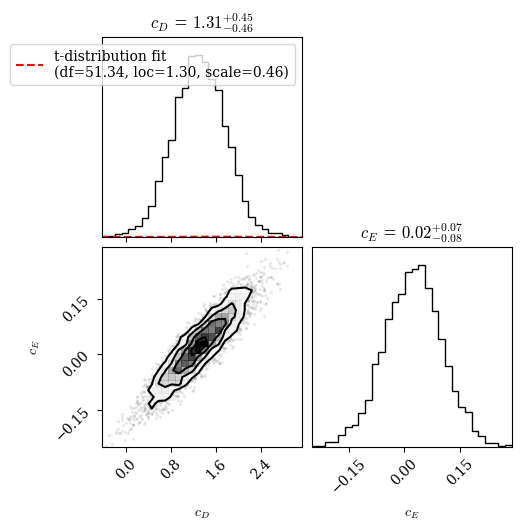

In [25]:
samples = sampler.get_chain(flat=True)
#plt.hist(samples[:, 1], 1000, color="k", histtype="step")
#plt.xlim(-1, 1)
#plt.show()

flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                show_titles=True, bins=30)
print(fig.get_axes())
for i in [0, 2]:
    ax = fig.get_axes()[i]
    for poly in ax.patches:
        # Each 'poly' is a Polygon object; we can extract the vertices
        verts = poly.get_xy()  # Get the vertices of the polygon
        # The x-values represent the bin edges, y-values represent the heights
        bin_left_edges = verts[:, 0]  # X-coordinates (bin edges)
        bin_heights = verts[:, 1]  # Y-coordinates (heights)

        # Print or store the bin edges and heights
        print(f"Bin edges: {bin_left_edges}")
        print(f"Bin heights: {bin_heights}")
    # Combine bin edges to get bin centers (for the data points)
    bin_centers = (bin_left_edges[:-1] + bin_left_edges[1:]) / 2

    # Fit a t-distribution to the histogram data
    df, loc, scale = stats.t.fit(flat_samples[:, i])  # Fit t-distribution to the i-th parameter

    # Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)
    pdf_fitted = stats.t.pdf(x, df, loc=loc, scale=scale)

    # Plot the t-distribution PDF over the histogram
    ax.plot(x, pdf_fitted, 'r--', label=f't-distribution fit\n(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})')

    # Optionally, add a legend
    #ax.legend()